# Modelling Energy Demand
 In this notebook we will try to predict the minimum and maximum energy demand with the end goal of looking at how the longterm demand is trending. We also want to see how residential solar fits into these models.

 ### Contents
 1. Linear Modelling
 2. XGBoost Modelling
    1. Maximum Demand Model
    2. Minimum Demand
 3. Future Prediction

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import multiprocessing
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import Holt

pd.plotting.register_matplotlib_converters()
%matplotlib inline
sns.set_theme()

Let's start by loading in our preprocessed data from the EDA.

In [67]:
df = pd.read_csv('../data/processed/all_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index()
df

,demand_min,demand_max,temp_min,temp_max,cum_output,population,dayofweek,month,year,dayofyear,public_holiday
datetime,,,,,,,,,,,
2010-01-01,6157.36,8922.42,22.1,28.8,3.036293e+04,7.144292e+06,4,1,2010,1,1
2010-01-02,6112.73,9326.64,21.6,29.4,3.049634e+04,7.144495e+06,5,1,2010,2,0
2010-01-03,6014.91,8277.85,17.9,21.5,3.062975e+04,7.144699e+06,6,1,2010,3,0
2010-01-04,6023.79,9522.30,17.9,23.9,3.076316e+04,7.144902e+06,0,1,2010,4,0
2010-01-05,6287.12,10728.72,15.4,27.7,3.089657e+04,7.145106e+06,1,1,2010,5,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,6051.38,10871.75,14.8,32.5,3.490182e+06,8.093864e+06,3,11,2020,331,0
2020-11-27,6152.19,10173.41,18.6,26.3,3.493903e+06,8.093863e+06,4,11,2020,332,0
2020-11-28,6284.18,12421.83,18.3,40.4,3.497624e+06,8.093862e+06,5,11,2020,333,0


We have consistent data running from 1/1/2010 through to 30/11/2020. We can break this up into train/test splits, and we might use 1/1/2019 as the breakpoint to ensure we have ample training and validation data.

In [68]:
train_df = df[df.index < '2019-01-01']
test_df = df[df.index >= '2019-01-01']

## Linear Modelling
Now we have our data, let's build a few linear models with different architectures to see how they perform. We will use RMSE on the validation set to compare the models.

In [69]:
# start by making a model plugging in all predictors
lm1_min = smf.ols('demand_min ~ temp_min + temp_max + cum_output + population + dayofweek + month + year + dayofyear + public_holiday', data=train_df).fit()
lm1_max = smf.ols('demand_max ~ temp_min + temp_max + cum_output + population + dayofweek + month + year + dayofyear + public_holiday', data=train_df).fit()

In [70]:
print(lm1_min.summary())

                            OLS Regression Results                            
Dep. Variable:             demand_min   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     279.7
Date:                Sat, 15 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:56:02   Log-Likelihood:                -23682.
No. Observations:                3284   AIC:                         4.738e+04
Df Residuals:                    3274   BIC:                         4.745e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.657e+06   9.82e+04     27.

In [71]:
print(lm1_max.summary())

                            OLS Regression Results                            
Dep. Variable:             demand_max   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     182.7
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          1.85e-281
Time:                        10:56:02   Log-Likelihood:                -27236.
No. Observations:                3284   AIC:                         5.449e+04
Df Residuals:                    3274   BIC:                         5.455e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4.635e+06    2.9e+05     15.

In [72]:
# Calculate RMSE for models
print(f'RMSE for LM_1 min model: {np.sqrt(mean_squared_error(test_df["demand_min"],lm1_min.predict(test_df)))}')
print(f'RMSE for LM_1 max model: {np.sqrt(mean_squared_error(test_df["demand_max"],lm1_max.predict(test_df)))}')

RMSE for LM_1 min model: 548.2219054539413
RMSE for LM_1 max model: 1137.2503124076848


Most predictors look to be significant in this model, with the exception of 'month' in both models and 'day of the year' in the max model.
We can see that the model has assigned a large negative coefficient to the 'year' predictor, while 'cumulative output' has a small positive coefficent. The model may be confusing these variables due to their high correlation.

Now let's try adding in some data transformations.

In [73]:
lm2_min = smf.ols('demand_min ~ temp_min + I(temp_min**2) + temp_max + I(temp_max**2) + np.log(cum_output) + np.log(population) + dayofweek + month + year + dayofyear + public_holiday', data=train_df).fit()
lm2_max = smf.ols('demand_max ~ temp_min + I(temp_min**2) + temp_max + I(temp_max**2) + np.log(cum_output) + np.log(population) + dayofweek + month + year + dayofyear + public_holiday', data=train_df).fit()

In [74]:
print(lm2_min.summary())

                            OLS Regression Results                            
Dep. Variable:             demand_min   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     436.6
Date:                Sat, 15 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:56:02   Log-Likelihood:                -23135.
No. Observations:                3284   AIC:                         4.629e+04
Df Residuals:                    3272   BIC:                         4.637e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.694e+05   7.24

In [75]:
print(lm2_max.summary())

                            OLS Regression Results                            
Dep. Variable:             demand_max   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     716.5
Date:                Sat, 15 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:56:02   Log-Likelihood:                -25890.
No. Observations:                3284   AIC:                         5.180e+04
Df Residuals:                    3272   BIC:                         5.188e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           7.306e+05   1.67

In [76]:
print(f'RMSE for LM_2 min model: {np.sqrt(mean_squared_error(test_df["demand_min"],lm2_min.predict(test_df)))}')
print(f'RMSE for LM_2 max model: {np.sqrt(mean_squared_error(test_df["demand_max"],lm2_max.predict(test_df)))}')

RMSE for LM_2 min model: 440.02684590030697
RMSE for LM_2 max model: 1157.4436334312531


We can see that by adding in the square term of the temperatures and taking the log of the solar output and population, there has been a significant improvement in the RMSE on the test set for the Minimum model, however the Maximum model remains unchanged.
It seems that taking the log of the cumulative output and population has made it so the coefficients for cumulative output, population and year are closer to what you would expect; that is, a negative effect on demand for the cumulative demand, and a positive effect for the population.

Let's now try adding in some interactions between the temperature and cumulative output variables to see if solar output and weather has some effect on each other.

In [77]:
lm3_min = smf.ols('demand_min ~ temp_min * I(temp_min**2) * temp_max * I(temp_max**2) * np.log(cum_output) + np.log(population) + dayofweek + month + year + dayofyear + public_holiday', data=train_df).fit()
lm3_max = smf.ols('demand_max ~ temp_min * I(temp_min**2) * temp_max * I(temp_max**2) * np.log(cum_output) + np.log(population) + dayofweek + month + year + dayofyear + public_holiday', data=train_df).fit()

In [78]:
print(lm3_min.summary())

                            OLS Regression Results                            
Dep. Variable:             demand_min   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     151.2
Date:                Sat, 15 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:56:02   Log-Likelihood:                -22973.
No. Observations:                3284   AIC:                         4.602e+04
Df Residuals:                    3246   BIC:                         4.625e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [79]:
print(lm3_max.summary())

                            OLS Regression Results                            
Dep. Variable:             demand_max   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     291.5
Date:                Sat, 15 Apr 2023   Prob (F-statistic):               0.00
Time:                        10:56:02   Log-Likelihood:                -25501.
No. Observations:                3284   AIC:                         5.108e+04
Df Residuals:                    3246   BIC:                         5.131e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [80]:
print(f'RMSE for LM_3 min model: {np.sqrt(mean_squared_error(test_df["demand_min"],lm3_min.predict(test_df)))}')
print(f'RMSE for LM_3 max model: {np.sqrt(mean_squared_error(test_df["demand_max"],lm3_max.predict(test_df)))}')

RMSE for LM_3 min model: 398.6336630217637
RMSE for LM_3 max model: 1069.3954163700748


We can see that this model adds in a lot of variables, many with low significance and small coefficients, making it difficult to interpret. It has improved the performance on the test set significantly from Model 1, but it is potentially too complex. A lasso regularisation could assist in cleaning this model up.

Seeing as many of our variables are on different scales, let's now try adding in some normalisation to see if we can improve performance.

In [86]:
# First take the log of our cumulative output and population data
norm_df = df.copy()
norm_df[['ln_cum_output','ln_population']] = np.log(norm_df[['cum_output', 'population']])
norm_df.drop(['cum_output', 'population'], axis=1, inplace=True)

# Now fit the transformation
scaler = StandardScaler()
norm_df[norm_df.columns.difference(['demand_max', 'demand_min'])] = scaler.fit_transform(norm_df[norm_df.columns.difference(['demand_max', 'demand_min'])])

# Recreate Train/Test splits
norm_train_df = norm_df[norm_df.index < '2019-01-01']
norm_test_df = norm_df[norm_df.index >= '2019-01-01']

norm_train_df

,demand_min,demand_max,temp_min,temp_max,dayofweek,month,year,dayofyear,public_holiday,ln_cum_output,ln_population
datetime,,,,,,,,,,,
2010-01-01,6157.36,8922.42,1.834462,1.179074,0.499922,-1.597895,-1.577552,-1.724682,6.813851,-3.385018,-1.697353
2010-01-02,6112.73,9326.64,1.740112,1.297736,0.999969,-1.597895,-1.577552,-1.715144,-0.146760,-3.380508,-1.696655
2010-01-03,6014.91,8277.85,1.041923,-0.264652,1.500016,-1.597895,-1.577552,-1.705605,-0.146760,-3.376017,-1.695957
2010-01-04,6023.79,9522.30,1.041923,0.209997,-1.500267,-1.597895,-1.577552,-1.696067,-0.146760,-3.371547,-1.695259
2010-01-05,6287.12,10728.72,0.570173,0.961526,-1.000220,-1.597895,-1.577552,-1.686529,-0.146760,-3.367095,-1.694561
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,6001.25,11050.31,1.041923,1.831717,-0.000126,1.609752,0.966325,1.709067,-0.146760,0.908404,1.177721
2018-12-28,6269.06,11347.41,1.249492,2.128373,0.499922,1.609752,0.966325,1.718605,-0.146760,0.908925,1.178463
2018-12-29,6306.77,10910.29,1.174013,2.187704,0.999969,1.609752,0.966325,1.728144,-0.146760,0.909446,1.179205


In [92]:
lm4_min = smf.ols('demand_min ~ temp_min + I(temp_min**2) + temp_max + I(temp_max**2) + ln_cum_output + ln_population + dayofweek + month + year + dayofyear + public_holiday', data = norm_train_df).fit()
lm4_max = smf.ols('demand_max ~ temp_min + I(temp_min**2) + temp_max +  I(temp_max**2) + ln_cum_output + ln_population + dayofweek + month + year + dayofyear + public_holiday', data = norm_train_df).fit()

In [93]:
print(lm4_min.summary())

                            OLS Regression Results                            
Dep. Variable:             demand_min   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     436.6
Date:                Sat, 15 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:05:18   Log-Likelihood:                -23135.
No. Observations:                3284   AIC:                         4.629e+04
Df Residuals:                    3272   BIC:                         4.637e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5921.6364     12.452  

In [94]:
print(lm4_max.summary())

                            OLS Regression Results                            
Dep. Variable:             demand_max   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     716.5
Date:                Sat, 15 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:05:31   Log-Likelihood:                -25890.
No. Observations:                3284   AIC:                         5.180e+04
Df Residuals:                    3272   BIC:                         5.188e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         8767.6050     28.813  

In [96]:
print(f'RMSE for LM_4 min model: {np.sqrt(mean_squared_error(norm_test_df["demand_min"],lm4_min.predict(norm_test_df)))}')
print(f'RMSE for LM_4 max model: {np.sqrt(mean_squared_error(norm_test_df["demand_max"],lm4_max.predict(norm_test_df)))}')

RMSE for LM_4 min model: 440.02684588966673
RMSE for LM_4 max model: 1157.4436334416025


As we will be looking at predicting into the future, min/max scaling is not available to us as cumulative output and population will continue to grow, however with standard scaling it means the models performance on the test set is no better than the model of the same architecture without the scaling (LM2).

The best performing model was LM3, the model with variable interactions. Though this model could be considered too complex, it performs well enough on the test set relative to the other Linear Models that it seems to be a good choice. We will use this model as our baseline comparison when comparing to the performance of future models.

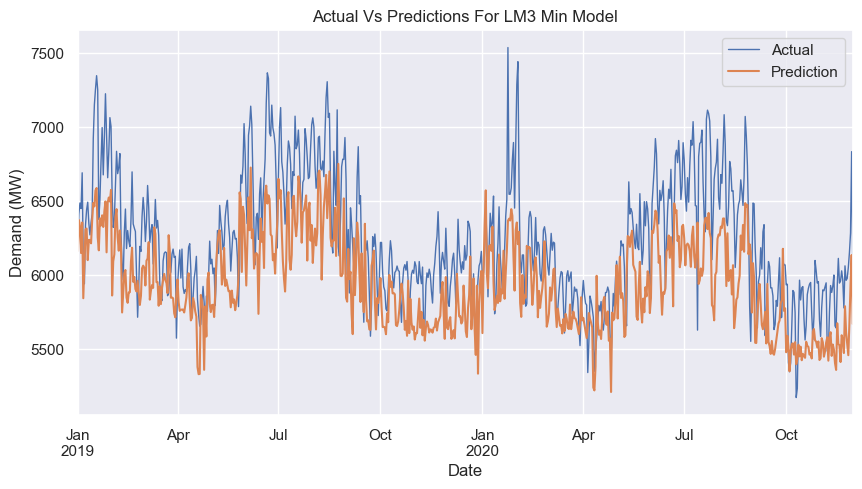

In [103]:
ax = test_df['demand_min'].plot(figsize=(10, 5), ms=1, lw=1, title='Actual Vs Predictions For LM3 Min Model')
pd.DataFrame({'Predictions':lm3_min.predict(test_df)}, index=test_df.index).plot(ax=ax)
plt.ylabel('Demand (MW)')
plt.xlabel('Date')
plt.legend(['Actual', 'Prediction'])
plt.savefig('../images/modelling/lm3-min-actualvpred.png')

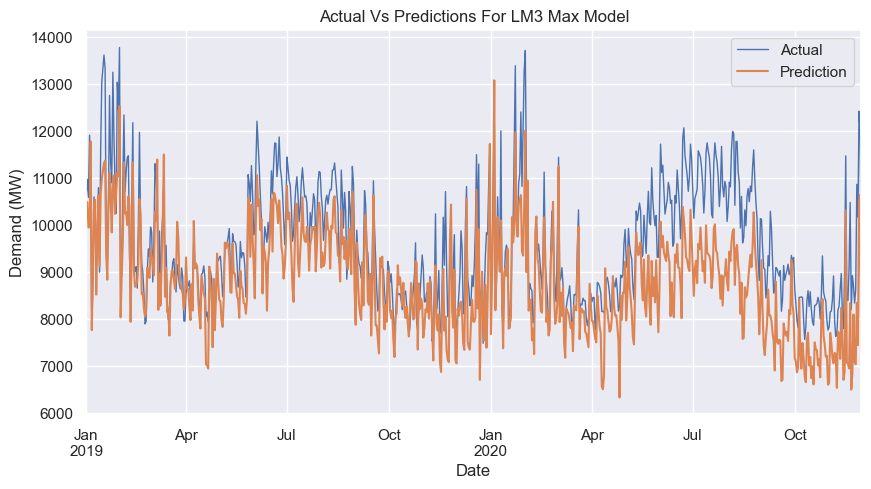

In [104]:
ax = test_df['demand_max'].plot(figsize=(10, 5), ms=1, lw=1, title='Actual Vs Predictions For LM3 Max Model')
pd.DataFrame({'Predictions':lm3_max.predict(test_df)}, index=test_df.index).plot(ax=ax)
plt.ylabel('Demand (MW)')
plt.xlabel('Date')
plt.legend(['Actual', 'Prediction'])
plt.savefig('../images/modelling/lm3-max-actualvpred.png')

We can see that the LM models tend to bias lower than the expected demand. While the models seem to do a reasonable job of matching yearly seasonal trends, it does not do very well at predicting when there will be a large spike in demand. These problems are likely due to a lack of flexibility in the linear regression models.

## XGBoost Modelling
As model flexibility seemed to be limiting the performance of the linear models, let's now try using XGBoost models to see if we can improve our predictive ability.
XGBoost is known for its flexibility and we will not need to worry about scaling data, as we would if we wanted to use other Machine Learning techniques.

In [105]:
# set up data for model
y_min = df['demand_min']
y_max = df['demand_max']
X = df.drop(['demand_max', 'demand_min'], axis=1)

### Maximum Demand Prediction
Let's start by building a model to predict maximum demand.

We will get a starting point for our hyperparameters by using GridSearchCV. Due to time constraints, we will focus on the maximum depth and learning rate, we will keep the number of estimators high to see how the training performs.
5 folds of timeseries splits will be used to evaluate the performance of the model.

In [106]:
# set up model use grid search CV for starting place
search_params = {'max_depth': [4, 5, 6, 8], 'n_estimators':[4000], 'learning_rate': [0.01, 0.05]}
# Create 5, 1 year splits
splits = TimeSeriesSplit(n_splits=5, test_size=365)

xgb_model = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count()//2,
                             objective='reg:squarederror',
                             early_stopping_rounds=50,
                             booster='gbtree')
grid_reg_max = GridSearchCV(estimator=xgb_model,
                            param_grid=search_params,
                            cv=splits.split(X, y_max),
                            n_jobs=2,
                            verbose=1)
grid_reg_max.fit(X, y_max, eval_set=[(X, y_max)], verbose=100)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[0]	validation_0-rmse:9681.26396
[100]	validation_0-rmse:3598.20547
[200]	validation_0-rmse:1381.18322
[300]	validation_0-rmse:601.87843
[400]	validation_0-rmse:358.49710
[500]	validation_0-rmse:291.68376
[600]	validation_0-rmse:270.24559
[700]	validation_0-rmse:257.84402
[800]	validation_0-rmse:248.37746
[900]	validation_0-rmse:240.06663
[1000]	validation_0-rmse:234.37434
[1100]	validation_0-rmse:227.19470
[1200]	validation_0-rmse:221.09594
[1300]	validation_0-rmse:215.77274
[1400]	validation_0-rmse:211.62487
[1500]	validation_0-rmse:206.54576
[1600]	validation_0-rmse:201.89565
[1700]	validation_0-rmse:197.05387
[1800]	validation_0-rmse:193.52131
[1900]	validation_0-rmse:188.05964
[2000]	validation_0-rmse:183.43076
[2100]	validation_0-rmse:178.09297
[2200]	validation_0-rmse:172.58068
[2300]	validation_0-rmse:168.70671
[2400]	validation_0-rmse:164.60332
[2500]	validation_0-rmse:160.95531
[2600]	validation_0-rmse:157.96387
[270

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000232A752B290>,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=50,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=8, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=2,
             param_grid={'learning_rate': [0.01, 0.05],
                         'max_depth': [4, 5, 6, 8], 'n_estimators': [4000]},
             verbose=1)

In [107]:
print(grid_reg_max.best_params_)
print(grid_reg_max.best_score_)
print(np.sqrt(mean_squared_error(y_max, grid_reg_max.predict(X))))

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 4000}
0.8672364357502487
115.44013373325609


Using GridSearchCV in this way, it can be difficult to tell when over fitting is occurring in the models. We may be able to get a better idea of the best hyperparameters by a more manual approach to tuning.

In [108]:
def cv_test_xgb(x_df, y_df, num_est, depth, lr, early_stop):
    """
    Function for Time Series Cross Validation of an XGB Regressor Model
    """
    preds = []
    scores = []
    num_est_used = []

    tss = TimeSeriesSplit(n_splits=5, test_size=365)

    for train_idx, val_idx in tss.split(x_df):
        X_train = x_df.iloc[train_idx]
        X_test = x_df.iloc[val_idx]

        y_train = y_df.iloc[train_idx]
        y_test = y_df.iloc[val_idx]

        reg = xgb.XGBRegressor(base_score=0.5,
                               n_jobs=multiprocessing.cpu_count()//2,
                               booster='gbtree',
                               n_estimators=num_est,
                               early_stopping_rounds=early_stop,
                               objective='reg:squarederror',
                               max_depth=depth,
                               learning_rate=lr)
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)
        num_est_used.append(reg.best_iteration)

    print(f'Mean score: {np.mean(scores):0.3f}')
    print(f'Scores on each fold: {scores} \n')
    print(f'Mean number of estimators used: {np.mean(num_est_used):0.0f}')
    print(f'Number of estimators used in each fold: {num_est_used}')

Using the function let's try a number of different depths with a large number of estimators with early stopping to find a good place to stop training.

In [109]:
# The parameters here were tweaked to find a good combination, bringing in findings from the prior GridSearchCV
cv_test_xgb(X, y_max, 3000, 6, 0.01, 75)

[0]	validation_0-rmse:9778.46614	validation_1-rmse:9478.63766
[100]	validation_0-rmse:3641.81157	validation_1-rmse:3544.06812
[200]	validation_0-rmse:1397.62333	validation_1-rmse:1450.95042
[300]	validation_0-rmse:593.51673	validation_1-rmse:748.28359
[400]	validation_0-rmse:329.05030	validation_1-rmse:547.94423
[500]	validation_0-rmse:250.87397	validation_1-rmse:481.29726
[600]	validation_0-rmse:224.76601	validation_1-rmse:457.88245
[700]	validation_0-rmse:211.09421	validation_1-rmse:446.46141
[800]	validation_0-rmse:199.92219	validation_1-rmse:439.61086
[900]	validation_0-rmse:191.55365	validation_1-rmse:434.66050
[1000]	validation_0-rmse:182.38344	validation_1-rmse:432.70508
[1090]	validation_0-rmse:174.89425	validation_1-rmse:433.37132
[0]	validation_0-rmse:9735.72536	validation_1-rmse:9598.07932
[100]	validation_0-rmse:3623.88415	validation_1-rmse:3615.16045
[200]	validation_0-rmse:1389.90027	validation_1-rmse:1461.75089
[300]	validation_0-rmse:593.20743	validation_1-rmse:720.7325

Now that we have a good idea of the hyperparameters, let's break the data down into train/test sets and test the model. As we will be training on a larger dataset, we will increase the number of estimators slightly from the approximation found in the Cross Validation.

In [111]:
# create train/test splits based on train/test splits used in LM
y_min_model = train_df['demand_min']
y_max_model = train_df['demand_max']
X_model = train_df.drop(['demand_max', 'demand_min'], axis=1)

y_min_val = test_df['demand_min']
y_max_val = test_df['demand_max']
X_val = test_df.drop(['demand_max', 'demand_min'], axis=1)

In [112]:
# Train XGBoost regressor
reg_max = xgb.XGBRegressor(base_score=0.5,
                           n_jobs=multiprocessing.cpu_count()//2,
                           booster='gbtree',
                           n_estimators=1000,
                           objective='reg:squarederror',
                           max_depth=6,
                           learning_rate=0.01)
reg_max.fit(X_model, y_max_model,
            eval_set=[(X_model, y_max_model)],
            verbose=100)

[0]	validation_0-rmse:9702.08687
[100]	validation_0-rmse:3607.80173
[200]	validation_0-rmse:1384.63983
[300]	validation_0-rmse:598.49035
[400]	validation_0-rmse:349.79540
[500]	validation_0-rmse:279.92827
[600]	validation_0-rmse:255.20796
[700]	validation_0-rmse:241.43643
[800]	validation_0-rmse:230.79927
[900]	validation_0-rmse:222.66874
[999]	validation_0-rmse:215.52251


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=8, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [133]:
# Look at the error on the reserved set for comparison to the linear model
print(f'RMSE on test set: {np.sqrt(mean_squared_error(y_max_val, reg_max.predict(X_val)))}')

RMSE on test set: 442.01426025771775


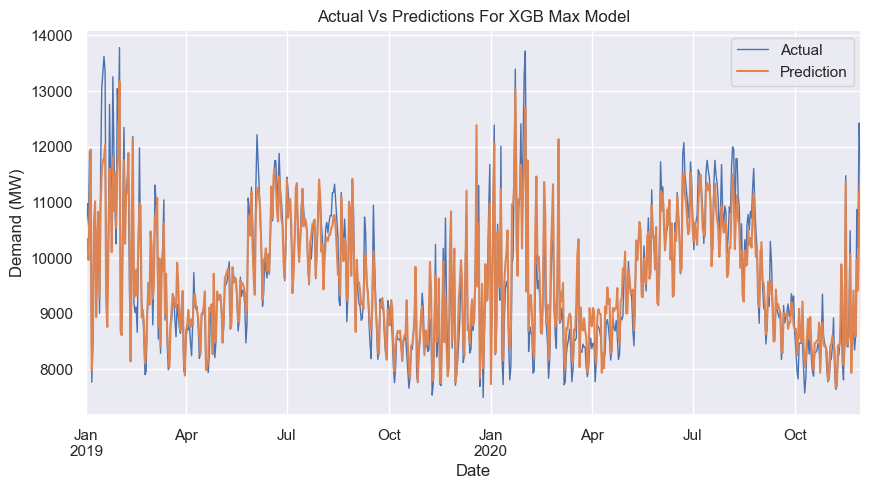

In [115]:
ax = y_max_val.plot(figsize=(10, 5), ms=1, lw=1, title='Actual Vs Predictions For XGB Max Model')
pd.DataFrame({'Predictions':reg_max.predict(X_val)}, index=y_max_val.index).plot(ax=ax)
plt.ylabel('Demand (MW)')
plt.xlabel('Date')
plt.legend(['Actual', 'Prediction'])
plt.savefig('../images/modelling/xgb-max-actualvpred.png')

We can see a significant improvement in the RMSE for the maximum prediction as the best LM only had a RMSE of 1069.40. We can also see that the yearly seasonality is much more closely matched. The model seems to have some shortcomings when trying to predict large deviations from seasonal trends.

### Minimum Demand Prediction
Let's now do the same process for creating a model for predicting the minimum daily demand.

In [116]:
# set up model use grid search CV for starting place
search_params = {'max_depth': [4, 5, 6, 8], 'n_estimators':[4000], 'learning_rate': [0.01, 0.05]}
# Create 5, 1 year splits
splits = TimeSeriesSplit(n_splits=5, test_size=365)

xgb_model = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count()//2,
                             objective='reg:squarederror',
                             early_stopping_rounds=50,
                             booster='gbtree')
grid_reg_min = GridSearchCV(estimator=xgb_model,
                            param_grid=search_params,
                            cv=splits.split(X, y_min),
                            n_jobs=2,
                            verbose=1)
grid_reg_min.fit(X, y_min, eval_set=[(X, y_min)], verbose=100)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[0]	validation_0-rmse:6189.00014
[100]	validation_0-rmse:2283.52402
[200]	validation_0-rmse:860.31037
[300]	validation_0-rmse:354.17729
[400]	validation_0-rmse:193.35441
[500]	validation_0-rmse:150.33772
[600]	validation_0-rmse:137.34940
[700]	validation_0-rmse:131.39829
[800]	validation_0-rmse:127.45736
[900]	validation_0-rmse:123.81633
[1000]	validation_0-rmse:120.64981
[1100]	validation_0-rmse:118.46695
[1200]	validation_0-rmse:115.91250
[1300]	validation_0-rmse:113.62718
[1400]	validation_0-rmse:111.71682
[1500]	validation_0-rmse:109.79671
[1600]	validation_0-rmse:108.03735
[1700]	validation_0-rmse:106.11375
[1800]	validation_0-rmse:104.65574
[1900]	validation_0-rmse:103.17045
[2000]	validation_0-rmse:101.44666
[2100]	validation_0-rmse:99.99616
[2200]	validation_0-rmse:98.42223
[2300]	validation_0-rmse:96.97451
[2400]	validation_0-rmse:95.56197
[2500]	validation_0-rmse:93.95763
[2600]	validation_0-rmse:92.52591
[2700]	vali

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000232B0B26150>,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=50,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=8, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=2,
             param_grid={'learning_rate': [0.01, 0.05],
                         'max_depth': [4, 5, 6, 8], 'n_estimators': [4000]},
             verbose=1)

In [117]:
print(grid_reg_min.best_params_)
print(grid_reg_min.best_score_)
print(np.sqrt(mean_squared_error(y_min, grid_reg_min.predict(X))))

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 4000}
0.7341612179241678
77.23170880501432


In [127]:
# Parameters were again tweaked to find a good model
cv_test_xgb(X, y_min, 3000, 6, 0.01, 75)

[0]	validation_0-rmse:6215.88346	validation_1-rmse:6023.50634
[100]	validation_0-rmse:2293.95974	validation_1-rmse:2240.09835
[200]	validation_0-rmse:863.04619	validation_1-rmse:870.21265
[300]	validation_0-rmse:351.34949	validation_1-rmse:396.86120
[400]	validation_0-rmse:186.70741	validation_1-rmse:252.44053
[500]	validation_0-rmse:143.24857	validation_1-rmse:213.42804
[600]	validation_0-rmse:130.34068	validation_1-rmse:203.52436
[700]	validation_0-rmse:124.62638	validation_1-rmse:199.17750
[800]	validation_0-rmse:120.96994	validation_1-rmse:197.26326
[900]	validation_0-rmse:118.03480	validation_1-rmse:196.31092
[1000]	validation_0-rmse:115.65127	validation_1-rmse:195.80493
[1100]	validation_0-rmse:113.00306	validation_1-rmse:194.14428
[1200]	validation_0-rmse:109.77886	validation_1-rmse:192.62569
[1300]	validation_0-rmse:107.13854	validation_1-rmse:191.44662
[1400]	validation_0-rmse:104.81137	validation_1-rmse:190.81764
[1500]	validation_0-rmse:102.79220	validation_1-rmse:190.72802


The CV was found to deviate from the GridSearchCV and it was found that a higher maximum depth was better.

In [138]:
# Train XGBoost Regressor
reg_min = xgb.XGBRegressor(base_score=0.5,
                           n_jobs=multiprocessing.cpu_count()//2,
                           booster='gbtree',
                           n_estimators=900,
                           objective='reg:squarederror',
                           max_depth=4,
                           learning_rate=0.01)
reg_min.fit(X_model, y_min_model,
            eval_set=[(X_model, y_min_model)],
            verbose=100)

[0]	validation_0-rmse:6187.40597
[100]	validation_0-rmse:2283.53061
[200]	validation_0-rmse:861.53132
[300]	validation_0-rmse:357.95607
[400]	validation_0-rmse:200.73808
[500]	validation_0-rmse:158.98774
[600]	validation_0-rmse:145.55804
[700]	validation_0-rmse:138.87521
[800]	validation_0-rmse:134.45515
[899]	validation_0-rmse:131.12255


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=900, n_jobs=8, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

In [139]:
# Look at the error on the reserved set for comparison to the linear model
print(f'RMSE on test set: {np.sqrt(mean_squared_error(y_min_val, reg_min.predict(X_val)))}')

RMSE on test set: 216.35892730608631


In this case, it was found that the model was over fitting to the training set, so the number of estimators had to be reduced to 900 and the maximum depth was reduced to 4.

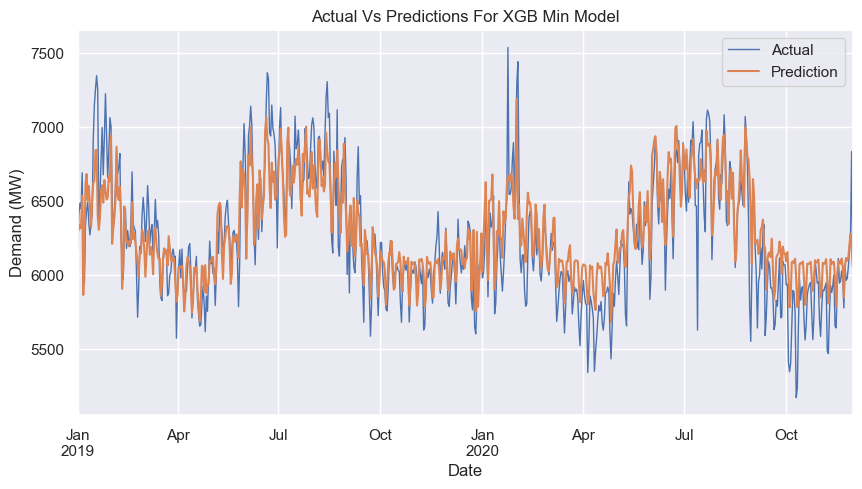

In [141]:
ax = y_min_val.plot(figsize=(10, 5), ms=1, lw=1, title='Actual Vs Predictions For XGB Min Model')
pd.DataFrame({'Predictions':reg_min.predict(X_val)}, index=y_min_val.index).plot(ax=ax)
plt.ylabel('Demand (MW)')
plt.xlabel('Date')
plt.legend(['Actual', 'Prediction'])
plt.savefig('../images/modelling/xgb-min-actualvpred.png')

Again, this model performs much better than the Linear Models. It seems to consistently overestimate very low demand. The model seems to deviate from actual more so in 2020 than in 2019, which could be due to COVID suppressing minimum demand from what you would typically expect; this may also be the reason why the model was overfitting and a model with less estimators and lower maximum depth actually performed better.

Let's now have a look at the feature importance for the models and see if the models match the multivariate analysis done in the EDA.